In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [2]:
tf.__version__
seed = 18
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(random)

In [3]:
names = []

with os.scandir('training/') as entries:
    for entry in entries:
        names.append("training/"+entry.name)

In [50]:
def toRep(inp, channels):
    cX = np.zeros((30, 30, 22+channels))
    for i in range(0, 10):
        clayer = inp[:, :] == i-1
        cX[:, :, i] = clayer
        cX[:, :, 10+i] = clayer
    return cX

def fromRep(rep):
    out = np.zeros((30, 30))
    toprint = rep[:, :, 0:11]
    toprint = np.argmax(toprint, axis=-1)-1
    return toprint

def plot(inp):
    plt.imshow(inp)
    plt.colorbar()
    plt.show()

def load(name, channels):
    X = []
    Y = []
    Xtest = []
    with open(name) as json_file:
        data = json.load(json_file) 
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            
            cX = np.zeros((30, 30, 20+channels))
            cY = np.zeros((30, 30, 20+channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            
            cX = toRep(cinr, channels)
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY = toRep(coutr, channels)
            
            X.append(cX)
            Y.append(cY)
            
        for t in data['test']:
            cX = np.zeros((30, 30, 20+channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            
            Xtest.append(toRep(cinr, channels))
            
    return [np.array(X), np.array(Y), np.array(Xtest)]

In [55]:
def loss_f(x, y):
    return tf.reduce_mean(tf.square(x[:, :, :, 0:10]-y[:, :, :, 0:10]))

def generate(model, cin, channels, iterations):
    mask = np.zeros((cin.shape[0], 30, 30, channels+22))
    mask[:, :, :, 10:22] = 1
    xl2 = cin*mask
    
    for i in range(iterations):
        cin += model(cin)
        cin = cin*(1-mask)+xl2
        if i%10 == 0:
            toprint = cin.numpy()[0]
            #plot(fromRep(toprint))
    
    toprint = cin.numpy()
    return toprint

def train(model, ctask, epochs, iterations, channels, verbose=False, validate=False, testtask=None):
    trainer = tf.keras.optimizers.Adam()

    origx = ctask[0]
    x = origx.copy()
    y = ctask[1]

    mask = np.zeros((x.shape[0], 30, 30, channels+22))
    mask[:, :, :, 10:22] = 1 
    xl2 = origx*mask

    for k in range(epochs):
        x = origx.copy()
        with tf.GradientTape() as g:
            for i in tf.range(iterations):
                x += model(x)
                x = x*(1-mask)+xl2
            loss = loss_f(x, y)
            grads = g.gradient(loss, model.weights)
            #grads = [g/(tf.norm(g)+1e-8) for g in grads]
            trainer.apply_gradients(zip(grads, model.weights))
        if k%5 == 0:
            generated = np.clip(np.round(generate(model, testtask, channels, iterations)), -1, 9)
            #groundtruth = wholetask[1]
            #valacc = testacc(generated, groundtruth)
            if verbose:
                plot(fromRep(generated[0]))
                print("LOSS AT EPOCH "+str(k)+": "+str(loss.numpy()))
                #print("LOSS AT EPOCH "+str(k)+": "+str(loss.numpy())+" TRAIN ACCURACY: "+str(np.sum(valacc[0:-1]))+" VALIDATION ACCURACY: "+str(valacc[-1]))
    return model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



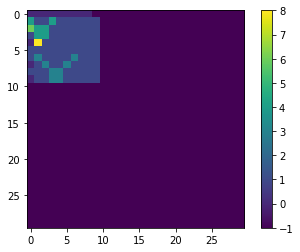

LOSS AT EPOCH 0: 0.003111111


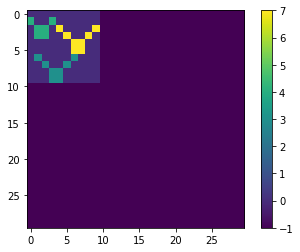

LOSS AT EPOCH 5: 0.08649142


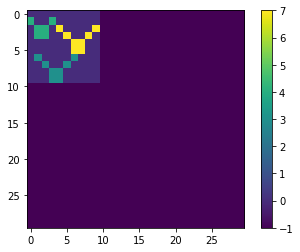

LOSS AT EPOCH 10: 0.011667782


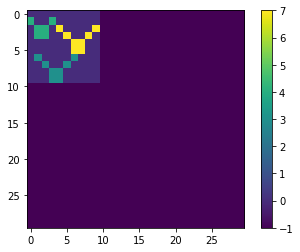

LOSS AT EPOCH 15: 0.015446397


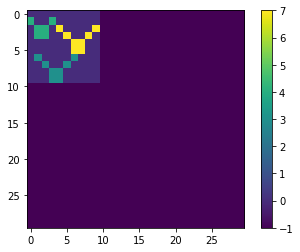

LOSS AT EPOCH 20: 0.0049630078


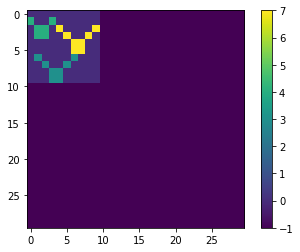

LOSS AT EPOCH 25: 0.0066017197


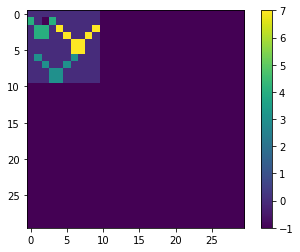

LOSS AT EPOCH 30: 0.003355541


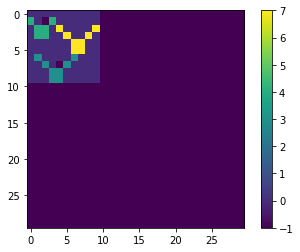

LOSS AT EPOCH 35: 0.0034783827


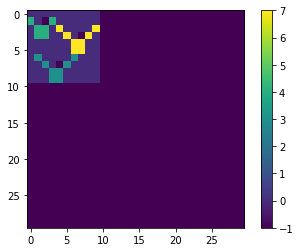

LOSS AT EPOCH 40: 0.002828914


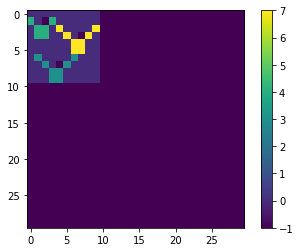

LOSS AT EPOCH 45: 0.002333994


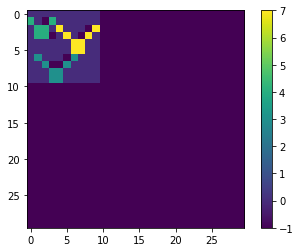

LOSS AT EPOCH 50: 0.0021085672


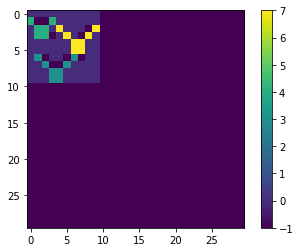

LOSS AT EPOCH 55: 0.0019164733


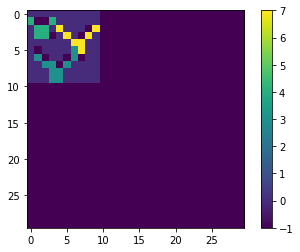

LOSS AT EPOCH 60: 0.0017837782


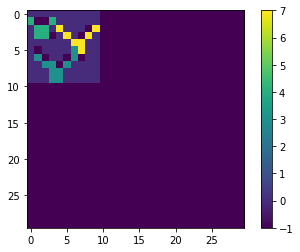

LOSS AT EPOCH 65: 0.0016496887


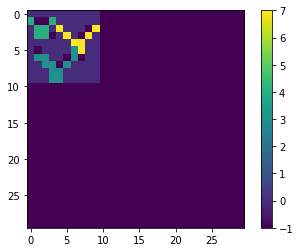

LOSS AT EPOCH 70: 0.0015303933


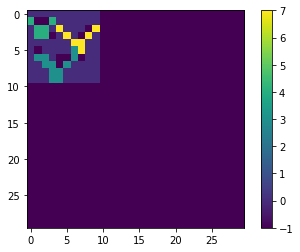

LOSS AT EPOCH 75: 0.001419552


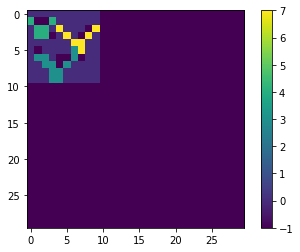

LOSS AT EPOCH 80: 0.0013169574


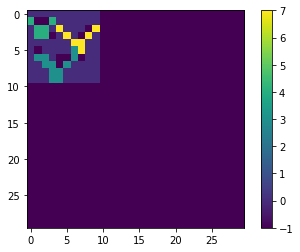

LOSS AT EPOCH 85: 0.0012241007


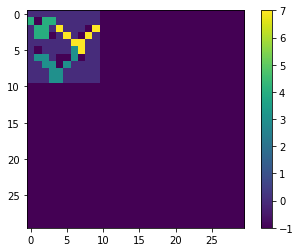

LOSS AT EPOCH 90: 0.0011392983


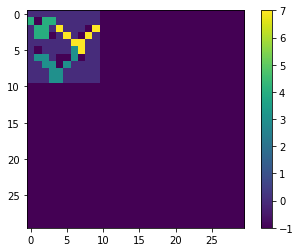

LOSS AT EPOCH 95: 0.0010584833


In [58]:
ntasks = 5
channels = 18
filters = 3
perceptionsize = 3
neurons = 128
epochs = 100
iterations = 200

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels+22), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels+22, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

ctask = load(names[104], channels)
cin = ctask[0:2]
ctest = ctask[2]
model = train(model, cin, epochs, iterations, channels, True, True, ctest)

TRAINING TASKS
IN


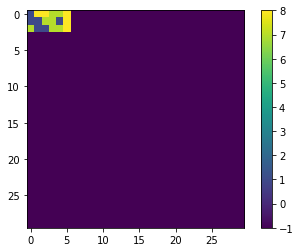

OUT


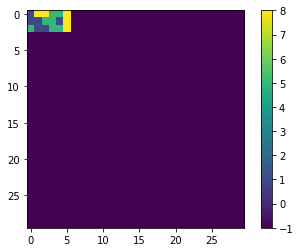

IN


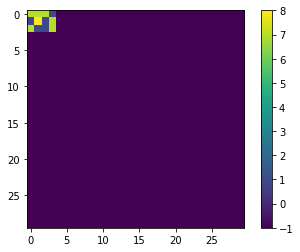

OUT


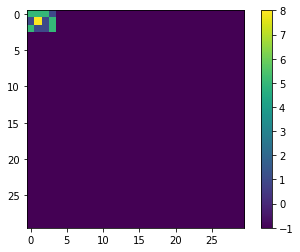

IN


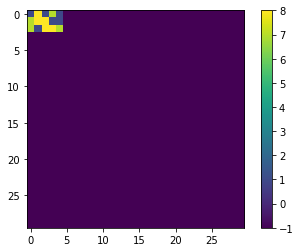

OUT


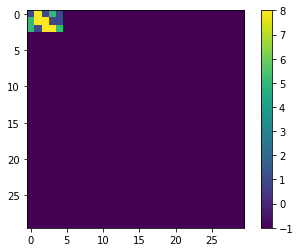

TEST IN


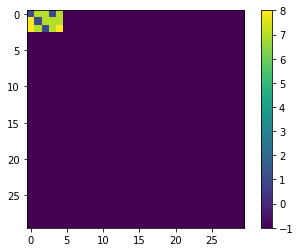

In [52]:
a = load(names[13], 10)

print("TRAINING TASKS")
for t in range(len(a[0])):
    print("IN")
    plot(fromRep(a[0][t]))
    print("OUT")
    plot(fromRep(a[1][t]))
print("TEST IN")
for t in range(len(a[2])):
    plot(fromRep(a[2][t]))